In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
from Preprocessing.labeling import resample_close, get_t1, get_events, get_lookback_vol
from Research.fx_utils import fx_data_import, bbg_data_import, macro_data_import
from Research.FXTesting import pca_distance_loop, get_nonusd_pair_data, get_nonusd_pairs, get_nonusd_close
from Preprocessing.sampling import _get_num_concurrent_events, _get_average_uniqueness
from Preprocessing.etf_trick import ETFTrick
from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_pnl
from Modelling.cross_val import PurgedKFold
from Modelling.feature_importance import get_pca_weights


home_machine = True
gen_tricks = False
start_date = dt.datetime(2000,1,1)
lookback = 500
# implement citi reversion



if home_machine:
    close = fx_data_import()
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes = get_nonusd_close(close, nonusd_pairs)
    tr_df = pair_closes.dropna(how='any')
else:
    close, yields = bbg_data_import(vs_dollar=True)
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes, cross_yields = get_nonusd_pair_data(close, yields, nonusd_pairs)
    cross_yields = cross_yields.fillna(0)/100./365.

if not gen_tricks:
    close = close.loc[start_date:]
    pair_closes = pair_closes.loc[start_date:]

#   if we wanted to drop the union of NAs
#    cross_yields = crosses.merge(yields, left_index=True, right_index=True, suffixes=('_px','_yld'))

# generate the indicator matrix whether pair is within cluster_threshold based on pca distances
group_matrix = pca_distance_loop(close, lookback, 4, 0.1, nonusd_pairs, components_to_use=[1,2,3])

# generate x-sigma signals
zscores = lookback_zscore(pair_closes, 30, lookback)
signals = zscore_signal(zscores, 2, 'Reversion')

# only take signals where the pair is 'grouped' at the time
group_signals = signals.multiply(group_matrix.loc[signals.index[0]:])
events_d = {}
tricks = []
if not gen_tricks:
    norm_srs = pd.read_excel(r"C:\Users\Brendan\FinML\MLFin\raw_data\nocarrytrickdata.xlsx", index_col=0)
    norm_srs = norm_srs.loc[start_date:]

for pair in nonusd_pairs:
    # skip if theres no group
    if (len(group_signals[pair][abs(group_signals[pair])>0]) == 0) or pair not in norm_srs.columns:
        continue
    
    print(pair, dt.datetime.now())
    
    weights = pd.DataFrame(np.ones(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
    
    # ETF trick on one pair
    # check if we're using yields
    if gen_tricks:
        if home_machine:
            carry = pd.DataFrame(np.zeros(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, carry)

        else:
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, cross_yields)
        tr_s = tr.get_etf_series()
        tricks.append(tr_s)
    else:
        tr_s = norm_srs.loc[:,pair]
        
    events0 = zscore_sizing(group_signals[pair], pair_closes[pair], 400, 50, lookback, pt_sl=(1,4))
    if events0 is None:
        continue
    events = generate_pnl(events0, tr_s)
    events_d[pair] = events



BRLCAD 2020-04-25 14:43:18.861872
BRLMXN 2020-04-25 14:43:19.079779
BRLZAR 2020-04-25 14:43:19.488532
BRLAUD 2020-04-25 14:43:19.855334
BRLNZD 2020-04-25 14:43:20.064250
CADMXN 2020-04-25 14:43:20.233140
CADNOK 2020-04-25 14:43:20.466019
CADSEK 2020-04-25 14:43:20.620936
CADZAR 2020-04-25 14:43:20.771846
CADAUD 2020-04-25 14:43:20.955741
CADNZD 2020-04-25 14:43:21.223589
CNYSLR 2020-04-25 14:43:21.477501
DKKNOK 2020-04-25 14:43:21.766350
DKKSEK 2020-04-25 14:43:22.387828
DKKCHF 2020-04-25 14:43:22.933386
DKKEUR 2020-04-25 14:43:23.163310
DKKGBP 2020-04-25 14:43:24.111572
HKDTHB 2020-04-25 14:43:24.771398
INRKRW 2020-04-25 14:43:24.919391
INRTWD 2020-04-25 14:43:25.180279
JPYSGD 2020-04-25 14:43:25.425718
JPYGBP 2020-04-25 14:43:25.611625
KRWTWD 2020-04-25 14:43:25.984410
KRWTHB 2020-04-25 14:43:26.722304
MXNZAR 2020-04-25 14:43:26.762359
NOKSEK 2020-04-25 14:43:27.116203
NOKCHF 2020-04-25 14:43:27.850063
NOKEUR 2020-04-25 14:43:28.033053
NOKGBP 2020-04-25 14:43:28.678116
SEKCHF 2020-04

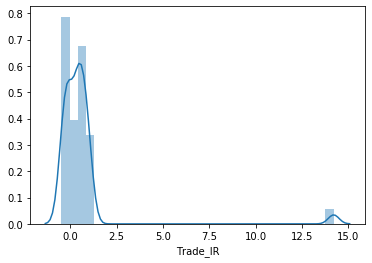

In [2]:
import seaborn as sns
cumul_pnl = pd.Series([e['ret'].sum() for key,e in events_d.items()], index=events_d.keys())
std_pnl = pd.Series([e['ret'].std() for key,e in events_d.items()], index=events_d.keys())
avg_pnl = pd.Series([e['ret'].mean() for key,e in events_d.items()], index=events_d.keys())
num_bets = pd.Series([e.shape[0] for key,e in events_d.items()], index=events_d.keys())
hit_ratio = pd.Series([e[e['ret']>0].loc[:,'ret'].count() for key,e in events_d.items()], index=events_d.keys())
pnl_df = pd.concat([cumul_pnl, std_pnl, avg_pnl, num_bets, hit_ratio/num_bets], axis=1, keys=['cumul','std','mean','num_bets','hit_ratio'])

# trade_ir not to be confused with strategy ir
# todo: method to generate daily mark to market
pnl_df['Trade_IR'] = pnl_df['mean']/pnl_df['std']
sns.distplot(pnl_df['Trade_IR'].dropna())

In [3]:
# lets put together some features
macro_data = macro_data_import().drop('PALLFNFINDEXM',axis=1)
macro_data = macro_data.rename({'Close':'VIX','PALLFNFINDEXM':'CommodIdx', 'DGS3MO': '3M_Bill','DFII10':'10Y_RY'}, axis=1)
macro_data = macro_data.replace(0, np.nan)
macro_data = macro_data.fillna(method='ffill')

# standardize
window = 125
macro_standard = macro_data.subtract(macro_data.rolling(window).mean())
macro_standard = macro_standard.divide(macro_standard.rolling(window).std())

# add in PCA space
pcs, pca = get_pca_weights(close, lookback, n_components=4, ret_pca=True)
X = close.dropna()
X = X.subtract(X.rolling(window).mean()).dropna()
X = X.divide(X.rolling(window).std()).dropna()

transformed = pd.DataFrame(pca.transform(X), index=X.index, columns=['pc'+str(i+1) for i in np.arange(4)])
macro_standard = macro_standard.merge(transformed, left_index=True, right_index=True)
macro_standard = macro_standard.loc[start_date:]
macro_standard.fillna(0, inplace=True)
macro_standard.tail()

,VIX,BAA10Y,3M_Bill,10Y_RY,pc1,pc2,pc3,pc4
2018-12-31,1.480430,3.406990,6.190435,0.336311,0.799638,-0.388830,1.101977,-2.381527
2019-01-01,1.463246,3.289683,6.097503,0.318399,0.761153,-0.388035,1.082359,-2.339970
2019-01-02,1.052318,3.183278,5.126887,0.089959,1.976011,-1.270413,0.969744,-2.223229
2019-01-03,1.443439,3.283059,4.703457,-0.755545,1.471584,-0.886230,1.102625,-1.656792
2019-01-04,0.689855,2.984311,4.858074,-0.451975,0.012200,-1.114093,0.665948,-1.234743


In [4]:
# let's train a forest on AUDNZD meanrev strategy
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import log_loss
from Preprocessing.sampling import _get_average_uniqueness, get_sample_weight
from Modelling.feature_importance import aux_feat_imp_sfi, feat_imp_mda
from Preprocessing.labeling import get_bins

pair = 'AUDNZD'

events = events_d[pair]
b = get_bins(events, norm_srs.loc[:, pair])
w = get_sample_weight(events['t1'], norm_srs.loc[:, pair])

# bin: signal results in trading gain: 1; or results in loss: 0
events['bin'] = b.loc[:, 'bin']
events['w'] = w
conc = _get_num_concurrent_events(norm_srs.index, events['t1'])
avg_uniq = _get_average_uniqueness(events['t1'], conc).mean()

clf = DecisionTreeClassifier(criterion='entropy', max_features='auto', class_weight='balanced')
bc = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_samples=avg_uniq, max_features=1.)

# reindex macro_standard to events starts
macro_standard = macro_standard.reindex(events.index)
imp = aux_feat_imp_sfi(macro_standard.columns, bc, macro_standard, events, 'accuracy', 5)
print(imp)
# mean decrease accuracy
imp_mda = feat_imp_mda(bc, macro_standard, events, scoring='accuracy', n_splits=5, pct_embargo=0.01)
print(imp_mda)


C:\Users\Brendan\FinML\MLFin\Preprocessing\sampling.py:196: RuntimeWarning: invalid value encountered in true_divide
  wgt = np.nansum(live_rets/num_conc_events[:, None].T, axis=1) # mx1


             mean        std
VIX      0.614695  0.0822816
BAA10Y   0.584325  0.0598463
3M_Bill  0.581022  0.0733811
10Y_RY    0.56046  0.0748731
pc1      0.636631  0.0515883
pc2       0.62598  0.0618836
pc3      0.436144  0.0913157
pc4      0.558552   0.070895
(             mean       std
VIX      0.017772  0.017772
BAA10Y   0.003058  0.025750
3M_Bill -0.004390  0.004390
10Y_RY  -0.023620  0.023620
pc1     -0.035537  0.035537
pc2      0.078346  0.078346
pc3      0.000000  0.000000
pc4      0.013382  0.019342, 0.6485818672428827)


2014-11-11    1.750440
2014-11-12    1.952495
2014-11-13    2.369594
2014-11-14    2.410051
2014-11-17    2.444871
2014-11-18    2.684747
2014-11-19    2.486591
2014-11-20    2.507855
2014-11-21    2.128727
2014-11-24    2.171702
2014-11-25    1.722003
2014-11-26    1.783680
2014-11-27    1.745212
2014-11-28    2.181181
2014-12-01    2.306643
2014-12-02    2.241850
2014-12-03    2.002416
2014-12-04    2.044369
2014-12-05    1.556199
2014-12-08    1.529139
2014-12-09    1.766450
2014-12-10    1.904747
2014-12-11    1.862844
2014-12-12    2.245309
2014-12-15    2.022214
2014-12-16    2.304245
2014-12-17    2.243570
2014-12-18    1.865253
2014-12-19    1.827447
2014-12-22    1.550673
                ...   
2020-01-06   -1.463000
2020-01-07   -1.336398
2020-01-08   -1.110977
2020-01-09   -1.295813
2020-01-10   -1.673620
2020-01-13   -1.642231
2020-01-14   -1.612864
2020-01-15   -1.392202
2020-01-16   -1.468402
2020-01-17   -1.634742
2020-01-20   -1.606142
2020-01-21   -1.668253
2020-01-22 

DATE
2014-12-16    2.628937
2014-12-18    2.178032
2014-12-19    2.159239
2014-12-22    1.852048
2014-12-23    1.837872
Name: BAA10Y, dtype: float64

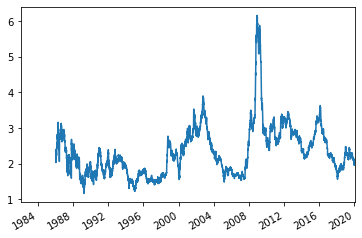

In [23]:
fig, ax = plt.subplots()
macro_data['BAA10Y'].plot(ax=ax)
print((macro_data['BAA10Y'].subtract(macro_data['BAA10Y'].rolling(window).mean())).divide(macro_data['BAA10Y'].rolling(window).std()).iloc[8650:])
macro_standard['BAA10Y'].tail()